In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
from keras.models import load_model

from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train,img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

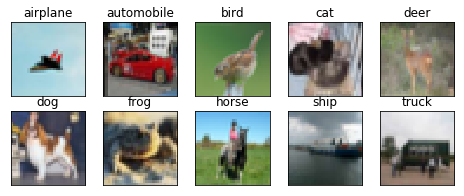

In [8]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#Convert the images in training dataset and test set into multidimentional arrays of their pixel intensity values.

train_features = train_features.reshape(train_features.shape[0], 32, 32,3)
test_features = test_features.reshape(test_features.shape[0], 32, 32,3)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [14]:
# Define the model
model = Sequential()
model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(32, 32, 3)))#32,3
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3, border_mode='same'))#32,5
model.add(BatchNormalization())
model.add(Activation('relu'))


# Transistion block 1
model.add(Convolution2D(64, 1))#32,5
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))#16,10
model.add(Dropout(0.25))


# Keeping the 'border = same' to achieve desired Receptive field towards the end
model.add(Convolution2D(64, 3, 3, border_mode='same'))#16,12
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3, border_mode='same'))#16,14
model.add(BatchNormalization())
model.add(Activation('relu'))


# Transistion block 2
model.add(Convolution2D(64, 1))#16,14
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))#8,28
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same'))#8,30
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(10, 1))#8,30
# Once the Resolution is less than 9x9, convolution with 3x3 will not cover all the pixels.
# So convolve with whatever is the size of the input channel i.e. 8x8 convolution
model.add(Convolution2D(10, 8))#8,38


model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        8256      
__________

In [1]:
	from google.colab import files
	src = list(files.upload().values())[0]
	open('random_eraser.py','wb').write(src)

Saving random_eraser.py to random_eraser.py


888

In [2]:
!cat random_eraser.py

import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


In [18]:
from keras.preprocessing.image import ImageDataGenerator
import random_eraser
from random_eraser import get_random_eraser

#Occultion is being used from the library 'random_erraser'.

  #The preprocessing function 'get_random_eraser(v_l=0, v_h=1,pixel_level=True)'
  #does pixel level occlution when pixel_level=True 
  #and occlution of dimention specified by v_l and v_h values.
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1,pixel_level=True))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
W0629 17:27:31.858896 139965539690368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions f

Epoch 1/100
390/390 [==============================] - 23s 58ms/step - loss: 1.4739 - acc: 0.4643 - val_loss: 1.2685 - val_acc: 0.5434
Epoch 2/100
390/390 [==============================] - 19s 49ms/step - loss: 1.0602 - acc: 0.6209 - val_loss: 1.8231 - val_acc: 0.4665
Epoch 3/100
390/390 [==============================] - 19s 48ms/step - loss: 0.9012 - acc: 0.6789 - val_loss: 0.9164 - val_acc: 0.6790
Epoch 4/100
390/390 [==============================] - 19s 48ms/step - loss: 0.8074 - acc: 0.7134 - val_loss: 0.8072 - val_acc: 0.7177
Epoch 5/100
390/390 [==============================] - 19s 48ms/step - loss: 0.7480 - acc: 0.7361 - val_loss: 0.8316 - val_acc: 0.7085
Epoch 6/100
390/390 [==============================] - 19s 48ms/step - loss: 0.6987 - acc: 0.7549 - val_loss: 0.7302 - val_acc: 0.7486
Epoch 7/100
390/390 [==============================] - 19s 48ms/step - loss: 0.6606 - acc: 0.7656 - val_loss: 1.0455 - val_acc: 0.6849
Epoch 8/100
390/390 [==============================] - 

In [0]:
#model.save("cifar10.h5")

In [0]:
#model = load_model('cifar10.h5')

In [0]:
  # file: string (name of existing file)
  # title: string (name which you want to give to the file being uploaded to Drive)
  # returns the file_id of the uploaded file on Drive
def upload_file_to_drive(file, title):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  export = drive.CreateFile({'title':title})  
  export.SetContentFile(file)
  export.Upload()

  return export['id']


  # file_id: string (id of the file you want to download)
  # title: string (name which you want to give to the file being downloaded)
def download_file_from_drive(file_id, title):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  download = drive.CreateFile({'id': file_id})
  download.GetContentFile(title)

In [0]:
#modelid = upload_file_to_drive("cifar10.h5","cifar100model")

#print(modelid)

In [0]:
#modelfile = download_file_from_drive("1LVnpbvm0han62oEGFacAgsjRcjVILAqK","cifar100model")

In [0]:
#model1 = load_model('cifar100model')


In [0]:
def grad_cam(img_path, model,rows,cols,lastlayer,lastlayerdepth):
 img = image.load_img(img_path, target_size=(rows, cols))
 x = image.img_to_array(img)
 x = np.expand_dims(x, axis=0)
 x = preprocess_input(x)
 preds = model.predict(x)
 class_idx = np.argmax(preds[0])
 class_output = model.output[:, class_idx]
 last_conv_layer = model.get_layer(lastlayer)
 grads = K.gradients(class_output, last_conv_layer.output)[0]
 pooled_grads = K.mean(grads, axis=(0, 1, 2))
 iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
 pooled_grads_value, conv_layer_output_value = iterate([x])
 for i in range(lastlayerdepth):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
 heatmap = np.mean(conv_layer_output_value, axis=-1)
 heatmap = np.maximum(heatmap, 0)
 heatmap /= np.max(heatmap)
 img = cv2.imread(img_path)
 heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
 heatmap = np.uint8(255 * heatmap)
 heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
 superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
 return img,superimposed_img


[Text(0.5, 0, 'Truck (Gradcam)')]

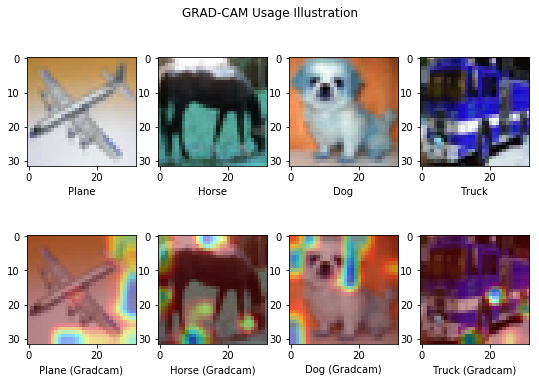

In [24]:
plane_img_path = "cifar10_test_images/airplane4.png"

horse_img_path = "cifar10_test_images/horse6.png"

dog_img_path = "cifar10_test_images/dog4.png"

truck_img_path = "cifar10_test_images/truck5.png"

lastlayer = "conv2d_17"
lastlayerdepth = 10
rows = 32
cols = 32

plane_img,superimposed_plane = grad_cam(plane_img_path, model,rows,cols,lastlayer,lastlayerdepth)

img_horse,superimposed_horse = grad_cam(horse_img_path, model,rows,cols,lastlayer,lastlayerdepth)

img_dog,superimposed_dog = grad_cam(dog_img_path, model,rows,cols,lastlayer,lastlayerdepth)

img_truck,superimposed_truck = grad_cam(truck_img_path, model,rows,cols,lastlayer,lastlayerdepth)



fig, axs = plt.subplots(ncols=4, nrows=2)
fig.suptitle('GRAD-CAM Usage Illustration', y=0.95)

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*1.5, Size[1]*1.5, forward=True)#Set forward to True to resize window along with plot in figure.

axs[0, 0].imshow(plane_img)
axs[0, 0].set(xlabel='Plane')

axs[0, 1].imshow(img_horse)
axs[0, 1].set(xlabel='Horse')

axs[0, 2].imshow(img_dog)
axs[0, 2].set(xlabel='Dog')

axs[0, 3].imshow(img_truck)
axs[0, 3].set(xlabel='Truck')

axs[1, 0].imshow(superimposed_plane)
axs[1, 0].set(xlabel='Plane (Gradcam)')

axs[1, 1].imshow(superimposed_horse)
axs[1, 1].set(xlabel='Horse (Gradcam)')

axs[1, 2].imshow(superimposed_dog)
axs[1, 2].set(xlabel='Dog (Gradcam)')

axs[1, 3].imshow(superimposed_truck)
axs[1, 3].set(xlabel='Truck (Gradcam)')